In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"
reslist = ['y1','h1y1']

In [5]:
altfile='yy_quadh_bkg10_soft025_md_allsig_{base}'
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


In [6]:
def load_reco_ranks(t, model=eightb.models.yy_quadh_bkg10_allsig):
    ranker = eightb.load_weaver_output(t, model=model.path, fields=['scores','mass_rank','nres_rank']+[f'{res}_m' for res in reslist])
    rename = dict(
        scores='reco_rank'
    ).get

    t.extend(
        **{
            rename(key,key):ak.from_regular(array)
            for key,array in ranker.items()
        }
    )

(signal+bkg).apply(load_reco_ranks)

[None, None, None, None, None]

In [7]:
event_filter = FilterSequence(
    eightb.selected_jet_pt(),
    eightb.selected_jet_btagwp()
)

signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

In [8]:
eightb_filter = EventFilter('eightb', filter=lambda t:t.nfound_select==8)
eightb_signal = signal.apply(eightb_filter)

In [9]:
class sample_rank(ObjTransform):
    def __call__(self, rank):
        sample = ak.from_regular(np.random.randint(315, size=(len(rank), self.n)))
        return rank[sample]

# $$ \text{mass rank} = 1 - \exp(-\frac{1}{2}\sum_{i=1}^4(\frac{m_i-125}{25})^2)$$ 

100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


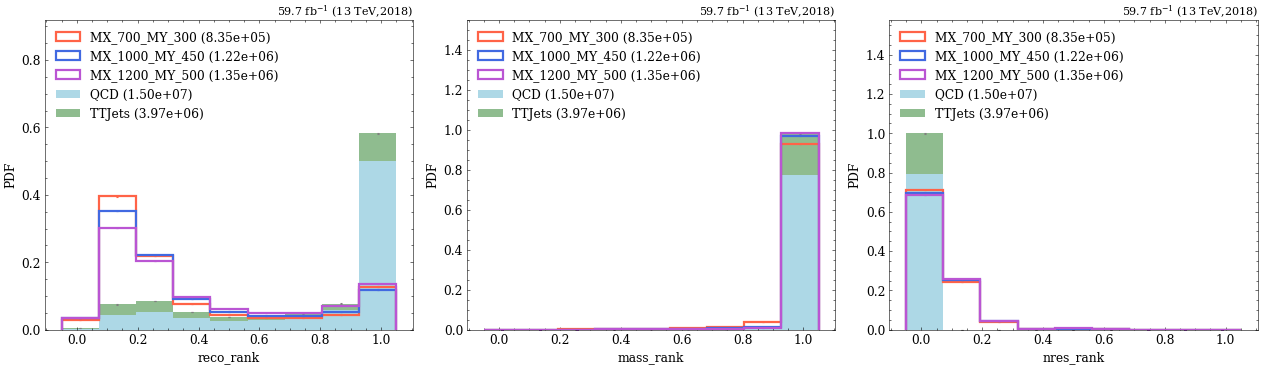

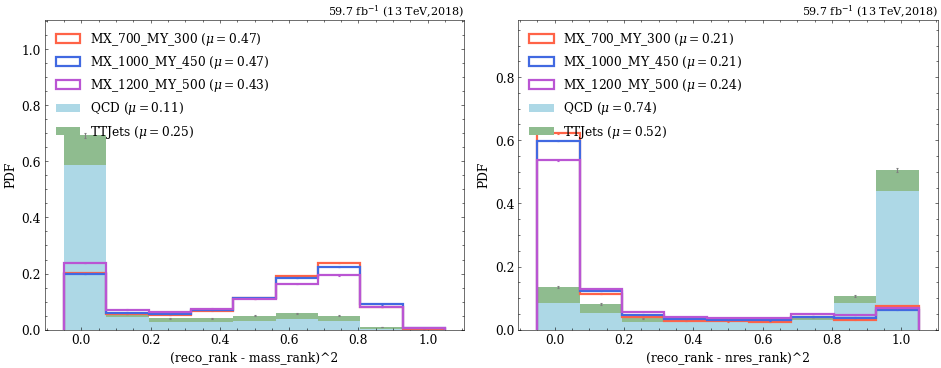

In [19]:
study.quick( 
    signal + bkg,
    legend=True,
    transforms=sample_rank(n=10),
    varlist=['reco_rank','mass_rank','nres_rank'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/t8btag_rank'
)
study.quick( 
    signal + bkg,
    legend=True, h_label_stat='mean',
    transforms=sample_rank(n=10),
    varlist=[lambda t : (t.reco_rank - t.mass_rank)**2,lambda t : (t.reco_rank - t.nres_rank)**2],
    xlabels=['(reco_rank - mass_rank)^2','(reco_rank - nres_rank)^2'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/t8btag_rank_chi2'
)

100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


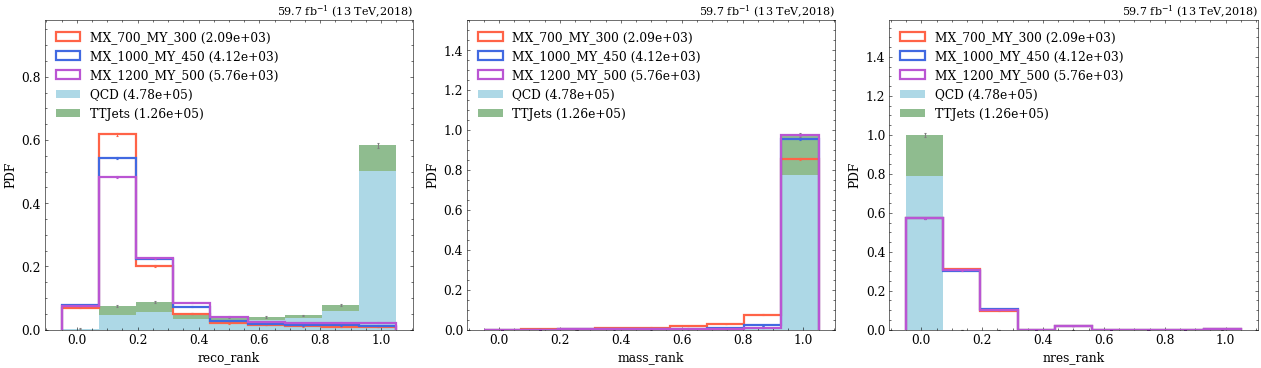

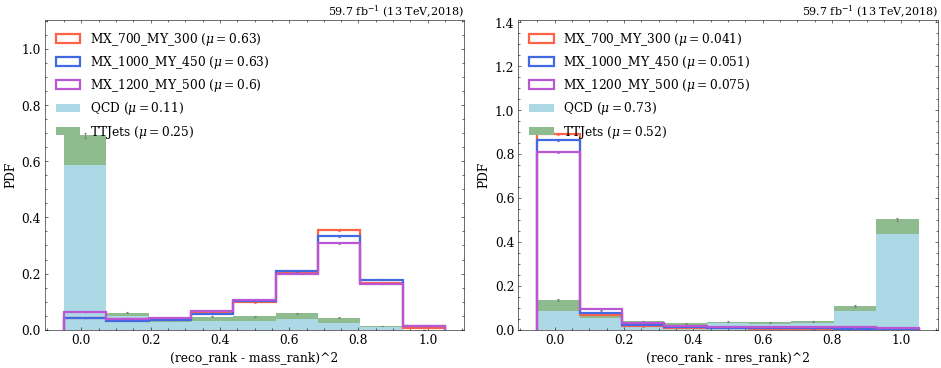

In [11]:
study.quick( 
    eightb_signal + bkg,
    legend=True,
    transforms=sample_rank(n=10),
    varlist=['reco_rank','mass_rank','nres_rank'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/eightb_rank'
)
study.quick( 
    eightb_signal + bkg,
    legend=True, h_label_stat='mean',
    transforms=sample_rank(n=10),
    varlist=[lambda t : (t.reco_rank - t.mass_rank)**2,lambda t : (t.reco_rank - t.nres_rank)**2],
    xlabels=['(reco_rank - mass_rank)^2','(reco_rank - nres_rank)^2'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/eightb_rank_chi2'
)

100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


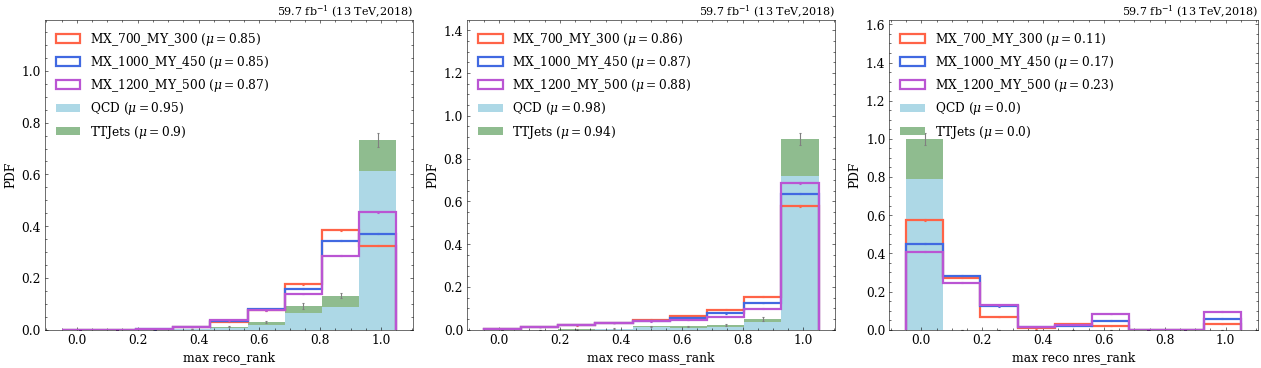

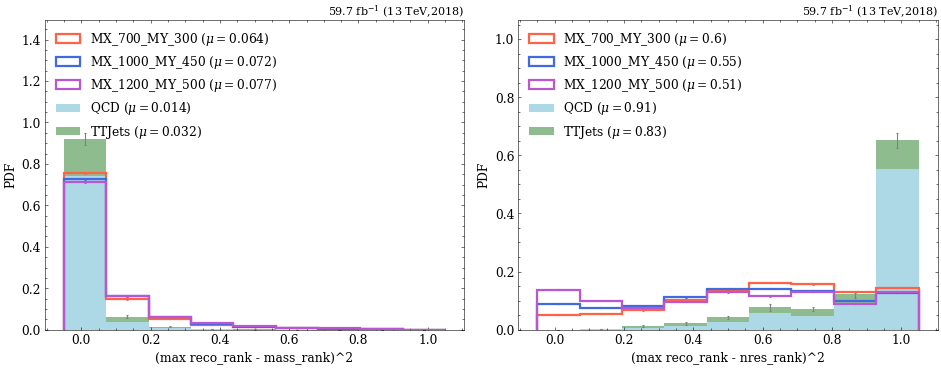

In [12]:
study.quick( 
    signal + bkg,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]],
    xlabels=['max reco_rank','max reco mass_rank','max reco nres_rank'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/t8btag_max_rank'
)
study.quick( 
    signal + bkg,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank - t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2,lambda t : (t.reco_rank - t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2],
    xlabels=['(max reco_rank - mass_rank)^2','(max reco_rank - nres_rank)^2'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/t8btag_max_rank_chi2'
)

100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


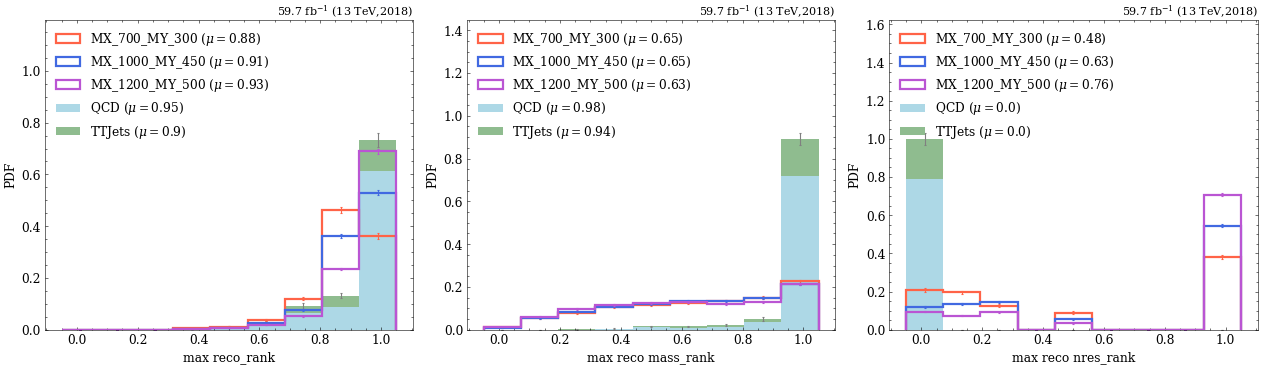

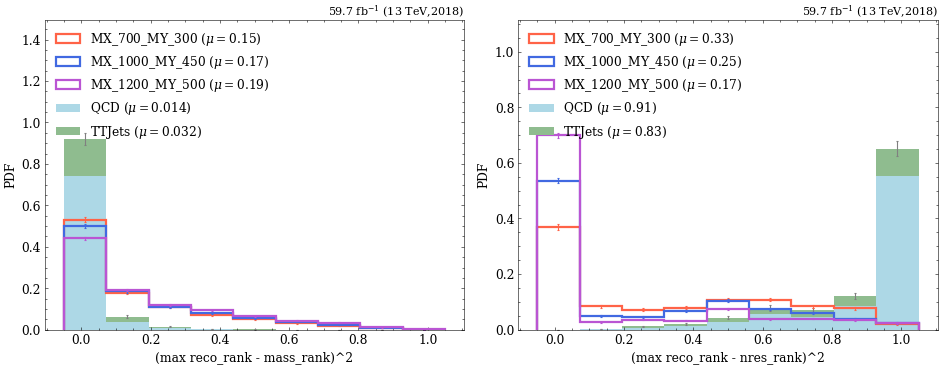

In [13]:
study.quick( 
    eightb_signal + bkg,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]],
    xlabels=['max reco_rank','max reco mass_rank','max reco nres_rank'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/eightb_max_rank'
)
study.quick( 
    eightb_signal + bkg,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank - t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2,lambda t : (t.reco_rank - t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2],
    xlabels=['(max reco_rank - mass_rank)^2','(max reco_rank - nres_rank)^2'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
    saveas=f'{dout}/ranker/eightb_max_rank_chi2'
)

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


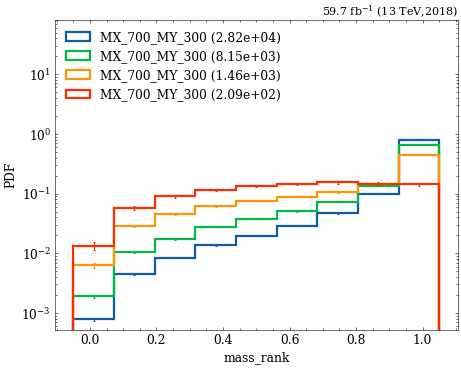

In [28]:
study.quick( 
    eightb_signal[[0]*4],
    h_color=None,
    indices=[lambda t:t.nres_rank>0, lambda t:t.nres_rank>0.2, lambda t:t.nres_rank>0.4, lambda t:t.nres_rank>0.8],
    legend=True,
    # transforms=sample_rank(n=10),
    varlist=['mass_rank'],
    binlist=[(-0.05,1.05,10)],
    log=True,
    efficiency=True,
    # dim=-1,
    # saveas=f'{dout}/ranker/eightb_rank'
)

In [30]:
def ordered_reco(t):

    order = ak.argsort(t.reco_rank,axis=-1,ascending=False)
    reco_ord = dict(
        reco_ord_rank=t.reco_rank[order],
        **{
            f'reco_ord_{res.lower()}_m': t[f'{res.lower()}_m'][order]
            for res in reslist
        }
    )

    t.extend(
        **reco_ord
    )
(eightb_signal+signal+bkg).apply(ordered_reco)

[None, None, None, None, None, None, None, None]

In [31]:
recos=np.linspace(0,314,4).astype(int)

100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


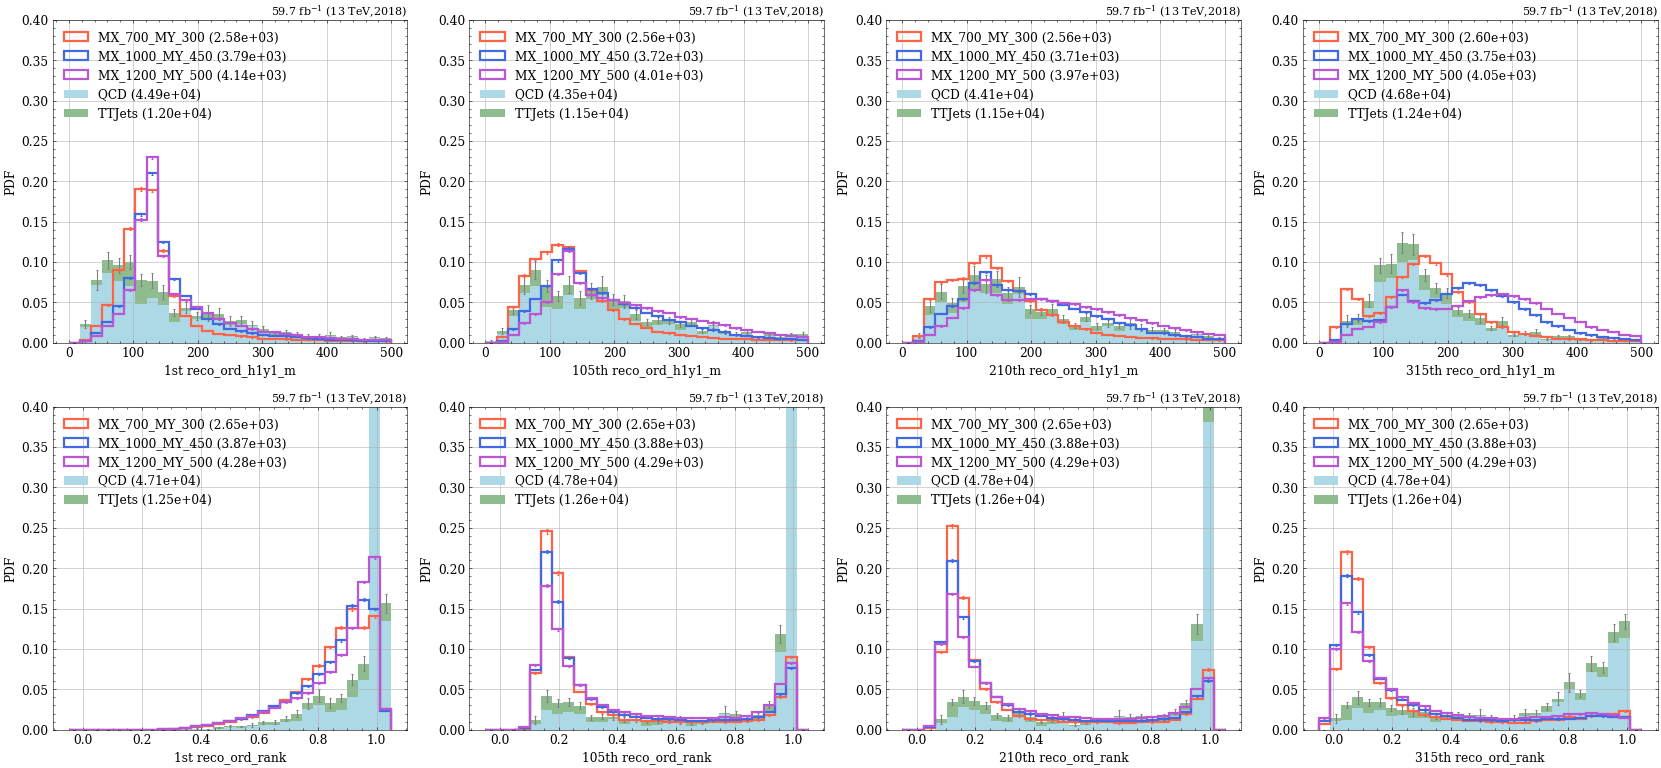

In [32]:
study.quick( 
    signal+bkg,
    legend=True,
    efficiency=True,
    varlist=[ f'reco_ord_h1y1_m[:,{i}]' for i in recos] + [ f'reco_ord_rank[:,{i}]' for i in recos],
    binlist=[(0,500,30)]*len(recos)+[(-0.05,1.05,30)]*len(recos),
    ylim=(0,0.4), grid=True,
    dim=(-1,4),
    saveas=f'{dout}/ranker/t8btag_rank_ord_h1y1'
)

100%|██████████| 8/8 [00:01<00:00,  6.68it/s]


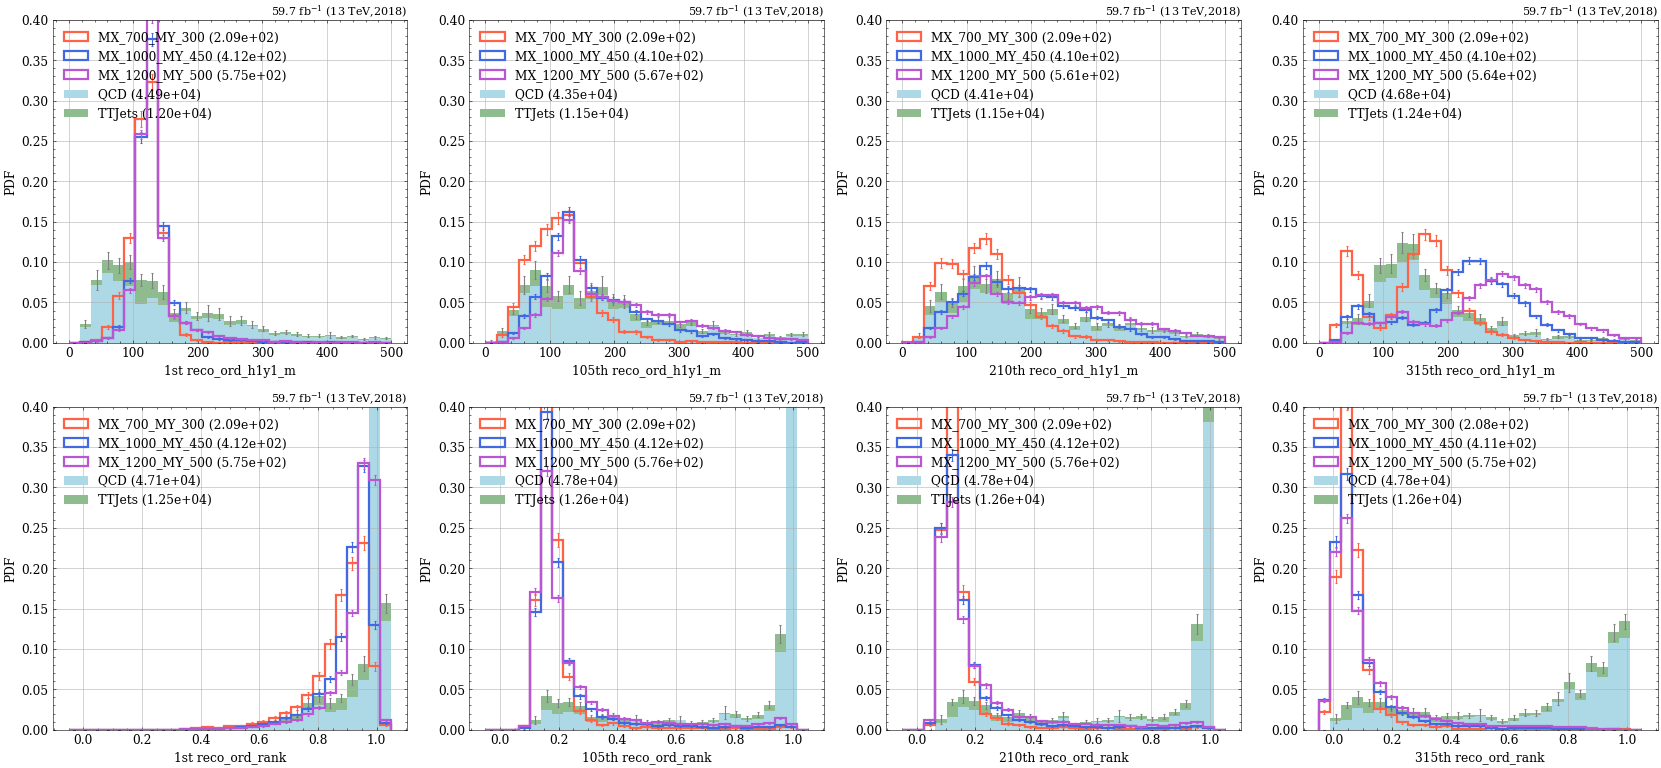

In [33]:
study.quick( 
    eightb_signal+bkg,
    legend=True,
    efficiency=True,
    varlist=[ f'reco_ord_h1y1_m[:,{i}]' for i in recos] + [ f'reco_ord_rank[:,{i}]' for i in recos],
    binlist=[(0,500,30)]*len(recos)+[(-0.05,1.05,30)]*len(recos),
    ylim=(0,0.4), grid=True,
    dim=(-1,4),
    saveas=f'{dout}/ranker/eightb_rank_ord_h1y1'
)

100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


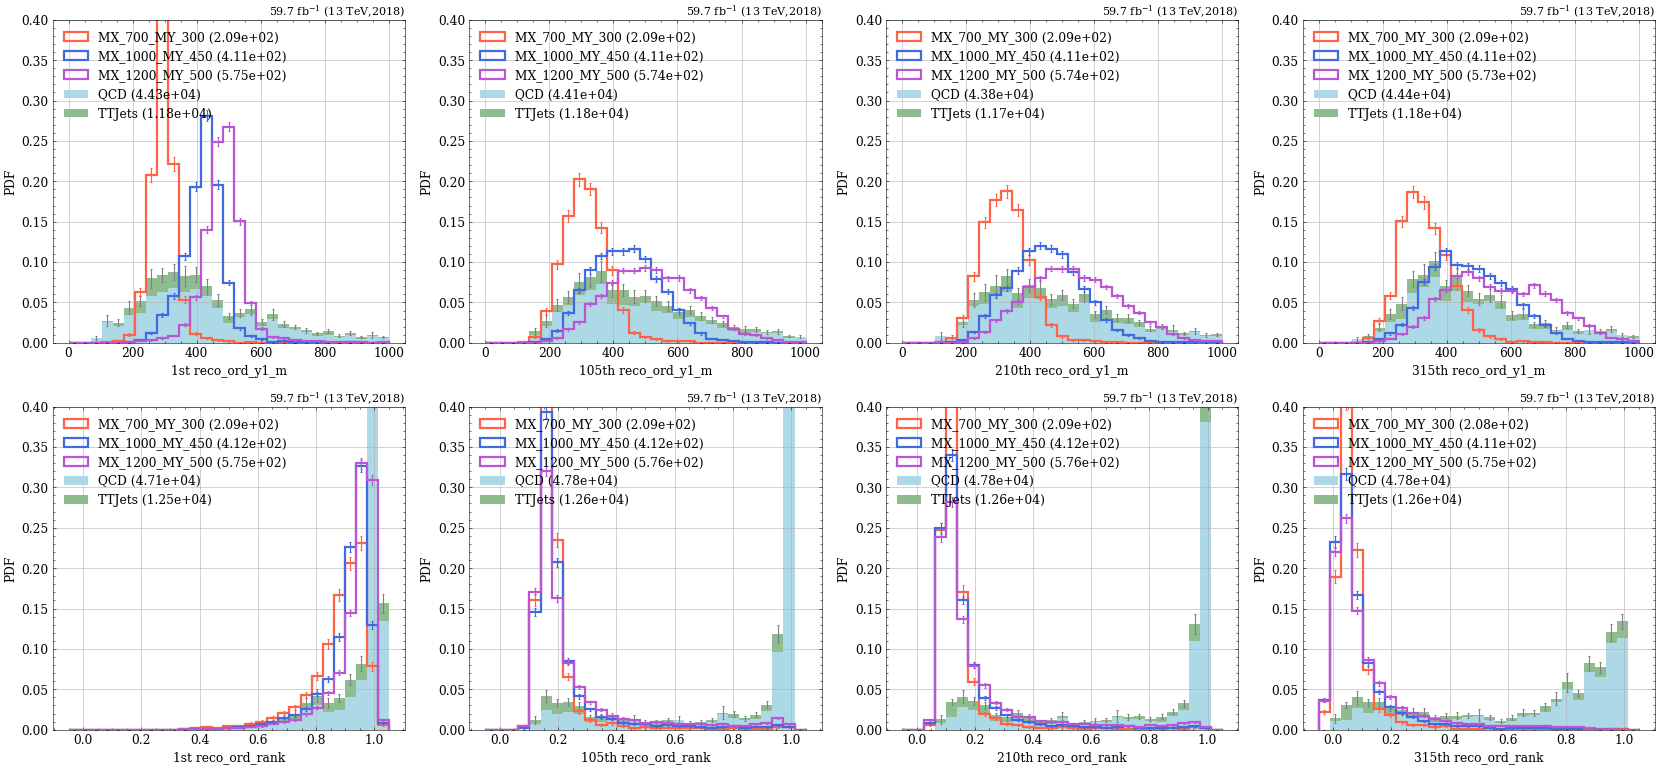

In [35]:
study.quick( 
    eightb_signal+bkg,
    legend=True,
    efficiency=True,
    varlist=[ f'reco_ord_y1_m[:,{i}]' for i in recos] + [ f'reco_ord_rank[:,{i}]' for i in recos],
    binlist=[(0,1000,30)]*len(recos)+[(-0.05,1.05,30)]*len(recos),
    ylim=(0,0.4), grid=True,
    dim=(-1,4),
    saveas=f'{dout}/ranker/eightb_rank_ord_y1'
)

100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


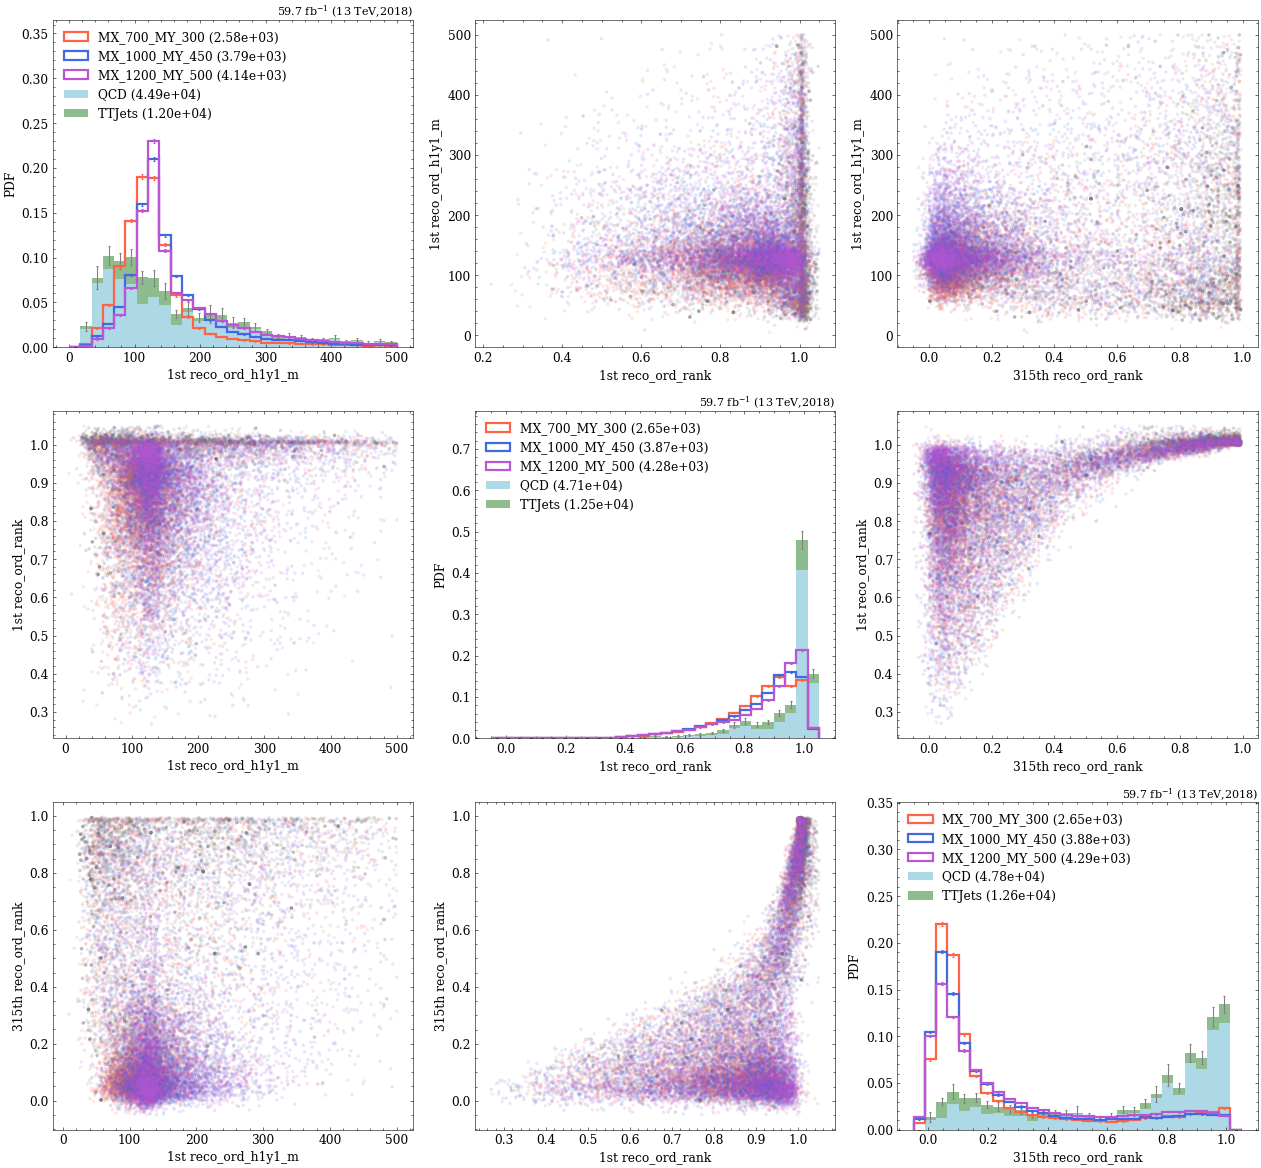

In [36]:
study.pairplot(
    signal+bkg,
    legend=True,
    varlist=['reco_ord_h1y1_m[:,0]','reco_ord_rank[:,0]','reco_ord_rank[:,314]'],
    binlist=[(0,500,30),(-0.05,1.05,30),(-0.05,1.05,30)],
    scatter=dict(fraction=5000, alpha=0.1),
    saveas=f'{dout}/ranker/t8btag_pairplot'
)

100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


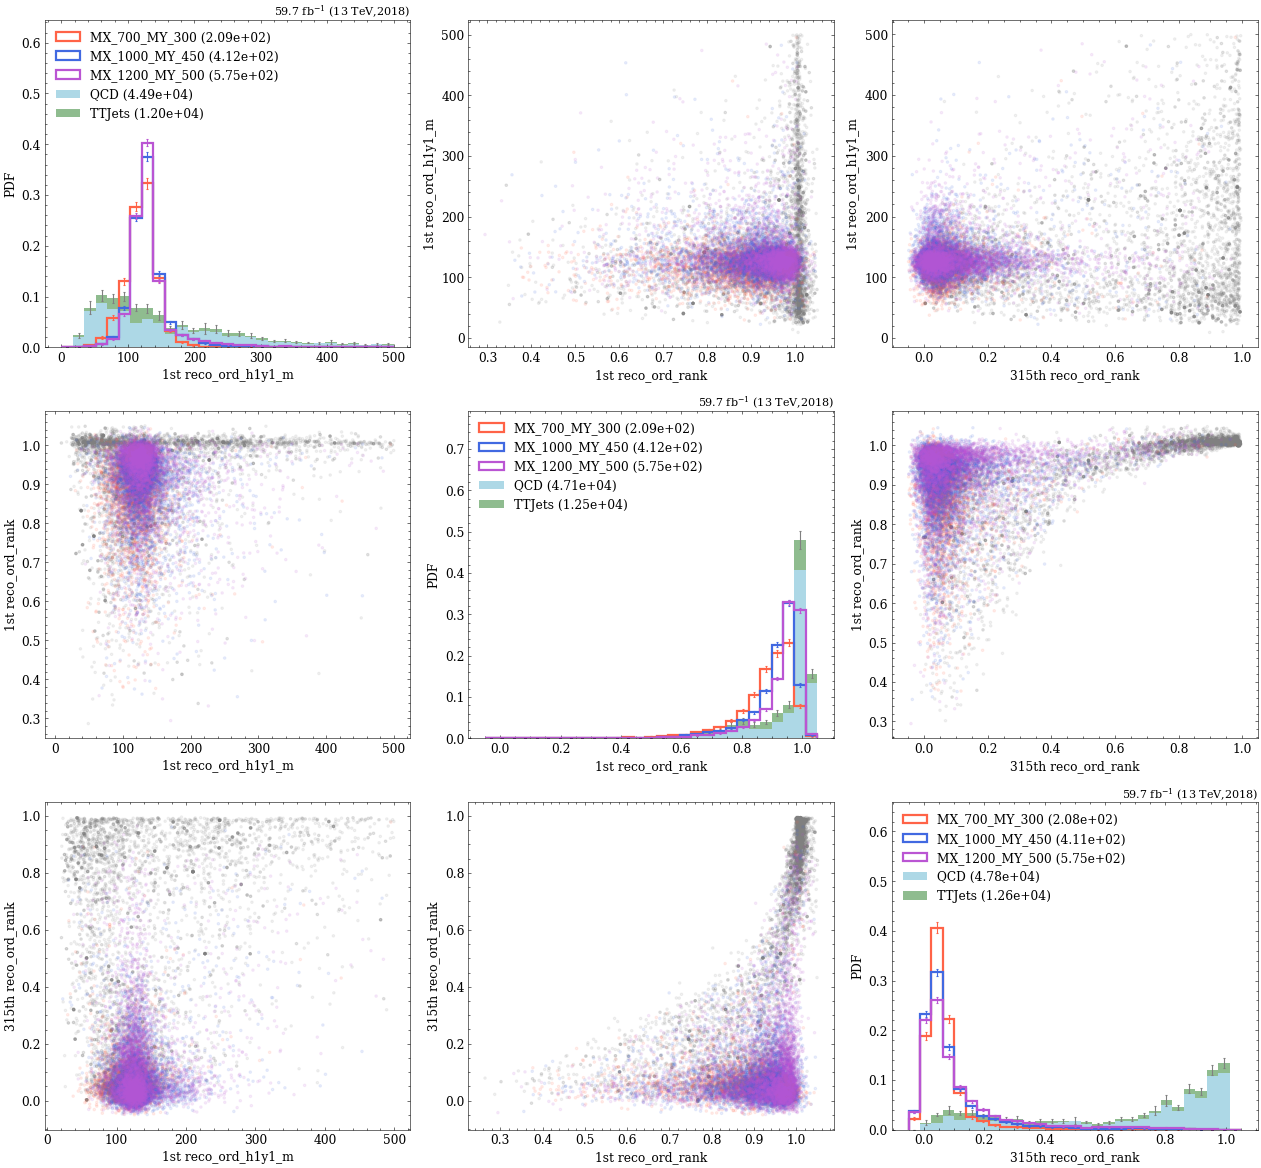

In [37]:
study.pairplot(
    eightb_signal+bkg,
    legend=True,
    varlist=['reco_ord_h1y1_m[:,0]','reco_ord_rank[:,0]','reco_ord_rank[:,314]'],
    binlist=[(0,500,30),(-0.05,1.05,30),(-0.05,1.05,30)],
    scatter=dict(fraction=5000, alpha=0.1),
    saveas=f'{dout}/ranker/eightb_pairplot'
)

In [50]:
h1y1_m  = (eightb_signal + bkg).reco_ord_h1y1_m
rank    = (eightb_signal + bkg).reco_ord_rank
weights = (eightb_signal + bkg).scale.list
sample  = (eightb_signal + bkg).sample.list
color   = (eightb_signal + bkg).color.list
is_signal = (eightb_signal + bkg).is_signal.list

In [62]:
histkwargs = dict(
    weights=weights,
    
    is_signal=is_signal,
    stacked=True,
    efficiency=True,

    h_color=color,
    h_label=sample,

    grid=True,
    ylim=(0,0.7),

    legend=True, 
    h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$', 
)

In [76]:
recos=np.linspace(0,314,315).astype(int)
for i in tqdm(recos):
    fig, axs = study.get_figax(nvar=2, size=(8,5))

    hist_multi(
        h1y1_m.apply(lambda m:m[:,i]).list,
        bins=(0,500,30),
        xlabel='$M_{H1Y1}$ (GeV)',
        figax=(fig, axs[0]),
        **histkwargs,
    )

    hist_multi(
        rank.apply(lambda r:r[:,i]).list,
        bins=(-0.05,1.05,30),
        xlabel=f'GNN Reconstruction Score',
        figax=(fig, axs[1]),
        **histkwargs,
    )

    fig.suptitle(f'{ordinal(i):>5} Reconstruction')

    study.save_fig(fig, f'yy_quadh/gif/eightb_reco_ord_{i:03}')

100%|██████████| 315/315 [08:46<00:00,  1.67s/it]


In [ ]:
# ffmpeg -framerate 25 -pattern_type glob -i 'eightb_reco_ord_*.jpg' -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ani_eightb_reco_ord.mp4